## Import packages

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read data

Read the file **sou_rec_pos.pkl** with pandas as DataFrame and the file **seismic_data_source_1000.nc** with xarray as DataSet

In [2]:
sou_rec_pos = pd.read_pickle("sou_rec_pos.pkl")
seismic_data= xr.open_dataset("seismic_data_source_1000.nc")
seismic_data

<xarray.Dataset>
Dimensions:  (twt: 4001, time: 4001, cdp: 1180)
Coordinates:
  * twt      (twt) float64 0.0 2.0 4.0 6.0 ... 7.996e+03 7.998e+03 8e+03
  * time     (time) float32 0.0 0.002 0.004 0.006 ... 7.994 7.996 7.998 8.0
  * cdp      (cdp) int32 871637 871638 871639 871640 ... 872814 872815 872816
Data variables:
    data     (cdp, time) float32 ...
Attributes: (12/13)
    ns:                  None
    sample_rate:         2.0
    text:                C 1 CLIENT                        COMPANY           ...
    measurement_system:  m
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         Niscota_4B.sgy
    srd:                 None
    datatype:            None
    percentiles:         [-8.89837605e+02 -8.00424402e+02 -1.07494686e+02  1....
    coord_scalar:        1.0

## Create new dimensions
Compute **Azimuth** and **Offset** from sources and receivers positions.

In [3]:
pos_x=np.array(sou_rec_pos['SourceX']-sou_rec_pos['GroupX'], dtype='f')
pos_y=np.array(sou_rec_pos['SourceY']-sou_rec_pos['GroupY'], dtype='f')
azimuth=np.arctan2(-pos_x, pos_y) * 180 / np.pi+180
offset = np.linalg.norm([pos_x,pos_y], axis=0)  
sou_rec_pos['Azimuth']=azimuth
sou_rec_pos['Offset']=offset
sou_rec_pos

,EnergySourcePoint,SourceX,SourceY,GroupX,GroupY,Azimuth,Offset
0,1,1182365,1105911,1181982,1106233,49.945190,500.372864
1,1,1182365,1105911,1182018,1106201,50.113312,452.226715
2,1,1182365,1105911,1182053,1106169,50.411865,404.855530
3,1,1182365,1105911,1182089,1106137,50.687988,356.723969
4,1,1182365,1105911,1182124,1106105,51.166656,309.381653
...,...,...,...,...,...,...,...
3566873,3645,1201128,1105871,1200942,1106056,45.154434,262.337555
3566874,3645,1201128,1105871,1200978,1106024,44.432739,214.263855
3566875,3645,1201128,1105871,1201013,1105992,43.543640,166.931122
3566876,3645,1201128,1105871,1201049,1105959,41.915192,118.258194


Histogram of the **Azimuth** for the source 1000.

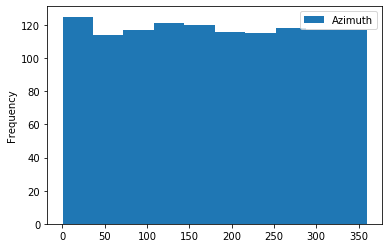

In [4]:
source=1000
shot_pos=sou_rec_pos[sou_rec_pos['EnergySourcePoint']==source]
shot_pos[['Azimuth']].plot.hist()
plt.show()

## Highligth position by azimuth bin
Show receivers fro the source 1000 with azimuth from 90 to 110.

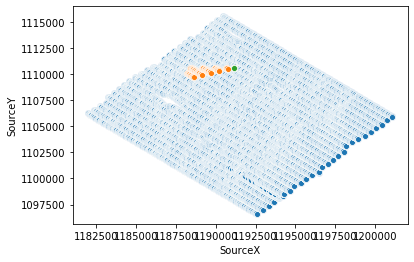

In [5]:
az_1=90 
az_2=110                  #Limit values of azimuth
shot_azimuth_pos=shot_pos[(shot_pos['Azimuth']>az_1)&(shot_pos['Azimuth']<az_2)]
sns.scatterplot(data=sou_rec_pos, x="GroupX", y="GroupY")
sns.scatterplot(data=shot_azimuth_pos, x="GroupX", y="GroupY")
sns.scatterplot(data=shot_azimuth_pos, x="SourceX", y="SourceY")
plt.show()

## Selecting traces for the azimuth bin
Create the azimuth coordinate for the DataSet **seismic_data**

In [6]:
seismic_data["azimuth"] = ("azimuth",  shot_pos['Azimuth'])
seismic_data["offset"] = ("azimuth",  shot_pos['Offset'])
seismic_data["data"] = (("azimuth", "time"), np.array(seismic_data.data))
seismic_data

<xarray.Dataset>
Dimensions:  (twt: 4001, time: 4001, azimuth: 1180, cdp: 1180)
Coordinates:
  * twt      (twt) float64 0.0 2.0 4.0 6.0 ... 7.996e+03 7.998e+03 8e+03
  * time     (time) float32 0.0 0.002 0.004 0.006 ... 7.994 7.996 7.998 8.0
  * cdp      (cdp) int32 871637 871638 871639 871640 ... 872814 872815 872816
  * azimuth  (azimuth) float32 120.7 121.5 122.4 123.3 ... 293.5 292.7 291.8
Data variables:
    data     (azimuth, time) float32 26.84 25.84 23.84 ... 9.652 10.65 6.652
    offset   (azimuth) float32 2.996e+03 2.982e+03 ... 2.963e+03 2.984e+03
Attributes: (12/13)
    ns:                  None
    sample_rate:         2.0
    text:                C 1 CLIENT                        COMPANY           ...
    measurement_system:  m
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         Niscota_4B.sgy
    srd:                 None
    datatype:            None
    percentiles:         [-8.89837605e+02 -8.00424402e+02 -1.07494686e+02  1....
    coord_scalar:        1.0

Select DataArray **data_azimuth** from the DataSet **seimisc_data** in the azimuth bin.

In [7]:
data = seismic_data.where((seismic_data.azimuth>az_1)&(seismic_data.azimuth<az_2), drop=True)  #Select traces for the azimuth bin
data_azimuth = data.data.sortby('azimuth') #Sort DataArray by azimuth
data_azimuth

<xarray.DataArray 'data' (azimuth: 65, time: 4001)>
array([[  8.409695  ,  -3.5903435 , -10.589903  , ...,  -6.589446  ,
         -0.5901154 ,  -7.5898438 ],
       [ 15.988307  ,  -6.011858  ,  -3.0117245 , ..., -38.012222  ,
         35.988754  ,   9.988281  ],
       [  4.1642447 ,   3.163847  ,  15.164299  , ...,  26.164795  ,
         18.163467  ,  19.164062  ],
       ...,
       [ -2.57061   ,  -6.570118  ,   7.429329  , ...,  -1.5695658 ,
          0.42876887,  -1.5703125 ],
       [  3.1287003 ,  -3.8710003 ,  -3.8710003 , ..., -52.871338  ,
        -54.871475  , -60.871094  ],
       [ -0.7927381 ,   4.2072372 ,  -9.793275  , ...,   1.2070312 ,
          6.2074423 ,  -5.7929688 ]], dtype=float32)
Coordinates:
  * time     (time) float32 0.0 0.002 0.004 0.006 ... 7.994 7.996 7.998 8.0
  * azimuth  (azimuth) float32 90.34 90.55 90.58 90.61 ... 109.1 109.6 109.9

Plot the shot gather foe the azimuth bin sort by azimuth.

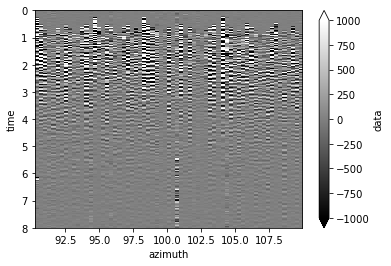

In [8]:
data_azimuth.plot.imshow('azimuth','time',cmap='gray', vmin=-1000, vmax=1000, origin='upper')

## Sort the data by offset
Select DataArray **data_offset** from the DataSet **data** in the azimuth bin.

In [9]:
data=data.swap_dims({"azimuth": "offset"})
data_offset = data.data.sortby('offset') #Sort DataArray by offset
data_offset

<xarray.DataArray 'data' (offset: 65, time: 4001)>
array([[ -6.117275  ,  -6.117275  ,  -4.117222  , ...,   0.88266945,
         -3.1167212 ,  -8.117185  ],
       [ 16.121216  ,   8.121343  ,   2.120884  , ...,  -6.8787937 ,
        -18.878708  , -29.878906  ],
       [ -9.644381  ,  -8.644425  ,  -5.644562  , ...,   0.3553915 ,
          5.3553143 ,  13.355469  ],
       ...,
       [ 44.947525  ,  36.948044  ,  36.948044  , ...,  44.948944  ,
         37.9494    ,  26.949219  ],
       [-40.781998  , -31.781235  , -24.782074  , ...,  25.218292  ,
          6.2188272 ,   8.21875   ],
       [-21.762146  , -25.761139  , -19.761536  , ...,  28.23848   ,
         18.238617  ,  23.238281  ]], dtype=float32)
Coordinates:
  * offset   (offset) float32 410.4 438.3 470.4 ... 2.951e+03 2.983e+03
  * time     (time) float32 0.0 0.002 0.004 0.006 ... 7.994 7.996 7.998 8.0
    azimuth  (offset) float32 104.1 98.93 94.39 90.34 ... 101.5 100.8 100.0

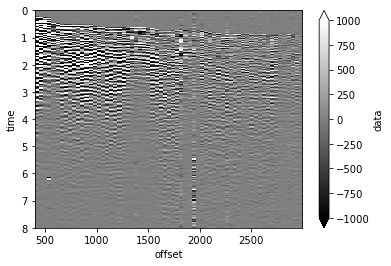

In [10]:
data_offset.plot.imshow('offset','time',cmap='gray', vmin=-1000, vmax=1000, origin='upper')

Plot the shot gather for the azimuth bin sort by offset.

Text(0, 0.5, 'Phase velocity (m/s)')

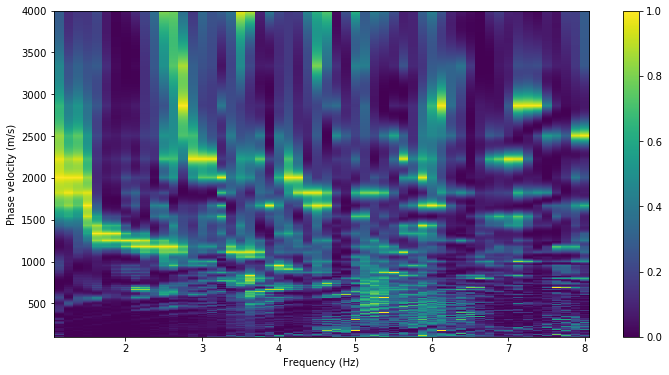

In [13]:
import masw_functions as mf
vmin=100.0 
vmax=4001.0
fmin=1.0 
fmax=8.0
pstep=5e-5
Nf=4001
v=np.arange(vmin,vmax)
D=mf.DispersionSpectrum(data_offset,v,fmin,fmax,Nf,pstep)
plt.rcParams['figure.figsize'] = [12, 6]
D.plot.imshow(D.dims[1],D.dims[0],cmap='viridis', origin='lower')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase velocity (m/s)")

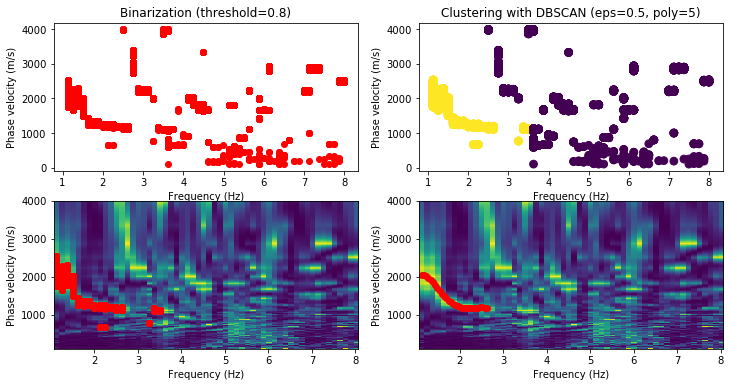

In [14]:
Xobs=mf.AutomaticPicking(D,threshold=0.8,num=30,fig=True)

Text(0, 0.5, 'Depth (m)')

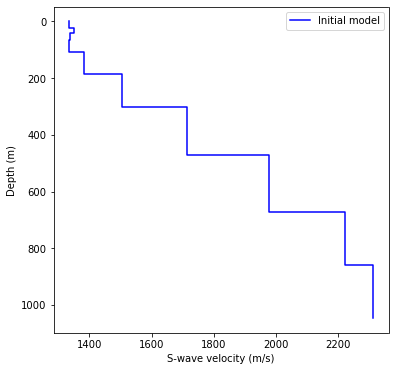

In [15]:
Nh=10
(vsia,hia,zia)=mf.InitialModel(Xobs,Nh)
plt.rcParams['figure.figsize'] = [6, 6]
plt.figure()
plt.step(np.append(vsia,vsia[-1]),zia,label='Initial model',color='blue')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("S-wave velocity (m/s)")
plt.ylabel("Depth (m)")

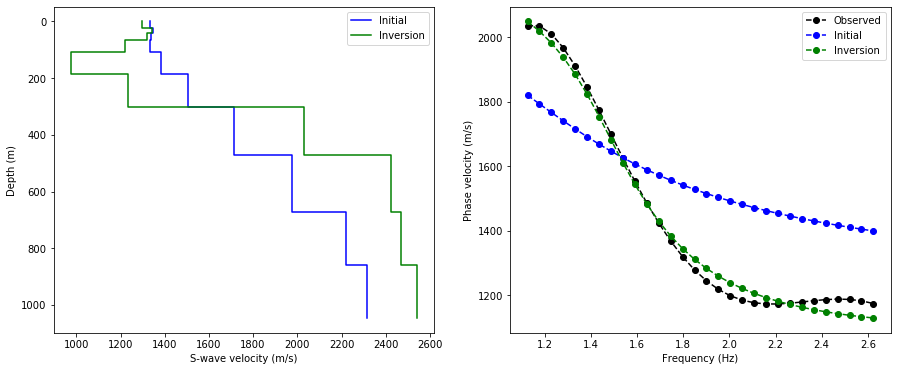

In [17]:
rps=2.5
alpha=Nh*10
n_iter=20
rhoia=2*np.ones(np.size(vsia))
dh=1.0
#(vsfa,vpfa,e)=mf.sw_inversion(Xobs[:,1],Xobs[:,0],vsia,rhoia,hia,rps,n_iter,alpha,dh)

plt.rcParams['figure.figsize'] = [15, 6]
fig, axs = plt.subplots(1,2)
axs[0].step(np.append(vsia,vsia[-1]),zia, color='blue', label='Initial')
axs[0].step(np.append(vsfa,vsfa[-1]),zia, color='green', label='Inversion')
axs[0].set(xlabel='S-wave velocity (m/s)', ylabel='Depth (m)')
axs[0].legend()
axs[0].invert_yaxis()

cRia=mf.forward_dispersion(vsia,rps*vsia,rhoia,hia,Xobs[:,0])
cRfa=mf.forward_dispersion(vsfa,rps*vsfa,rhoia,hia,Xobs[:,0])
axs[1].plot(Xobs[:,0], Xobs[:,1], 'o--', color='black', label='Observed')
axs[1].plot(Xobs[:,0], cRia, 'o--', color='blue', label='Initial')
axs[1].plot(Xobs[:,0], cRfa, 'o--', color='green', label='Inversion')
axs[1].set(xlabel='Frequency (Hz)', ylabel='Phase velocity (m/s)')
axs[1].legend()